# Basics: Light curve gradients
The cool thing about analytic expressions for light curves is that their derivatives are also analytic, and therefore fast to compute (and accurate!). We've coded up a lot of the flux derivatives in `starry`, but most of the heavy lifting is done using autodifferentiation. Let's go over how to compute gradients with some simple examples.

## Gradients of `Map` instances

Let's instantiate a low degree `Map` with some arbitrary spherical harmonic coefficients:

In [1]:
%matplotlib inline

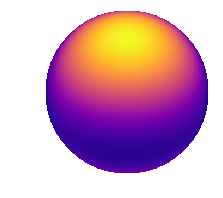

In [17]:
from starry import Map
map = Map(lmax=2)
map[1, 0] = 0.3
map[2, -1] = 0.3
map[2, 2] = -0.1
map.show()

We can compute the flux during an occultation as usual:

In [16]:
map.flux(xo=0.3, yo=0.4, ro=0.1)

1.3277964701859288

To also compute the gradient of the flux with respect to the input parameters, we can simply pass the `gradient=True` keyword:

In [3]:
flux, gradient = map.flux(xo=0.3, yo=0.4, ro=0.1, gradient=True)
print(flux)
print(gradient)

1.3277964701859288
{'theta': array([-6.89762425e-05]), 'xo': array([0.00460625]), 'yo': array([-0.006946]), 'ro': array([-0.37133373]), 'y': array([[ 0.99      ],
       [-0.0069282 ],
       [ 1.13975912],
       [-0.00519615],
       [-0.00464758],
       [-0.01331904],
       [ 0.54520927],
       [-0.00998928],
       [ 0.00135554]]), 'u': array([], shape=(0, 1), dtype=float64)}


What `starry` returns is the tuple `(F, dF)` of the flux and its gradient. The gradient `dF` is a dictionary of derivatives with respect to each of the input parameters (including `theta`, which we omitted in the call and whose default value is zero) and each of the spherical harmonic coefficients. The latter are given as a vector,

In [4]:
gradient['y']

array([[ 0.99      ],
       [-0.0069282 ],
       [ 1.13975912],
       [-0.00519615],
       [-0.00464758],
       [-0.01331904],
       [ 0.54520927],
       [-0.00998928],
       [ 0.00135554]])

where each element is the derivative with respect to the corresponding element in the `map.y` vector. Note that the gradient also contains an entry for the limb darkening coefficients `u`, but since we didn't set any, `starry` didn't bother computing those derivatives.

Note that the gradient routines are fully vectorized, so we can compute an entire light curve and its time-dependent gradients in a single pass:

In [5]:
import numpy as np
xo = np.linspace(-1.5, 1.5, 1000)
flux, gradient = map.flux(xo=xo, yo=0.4, ro=0.1, gradient=True)

Here's the light curve:

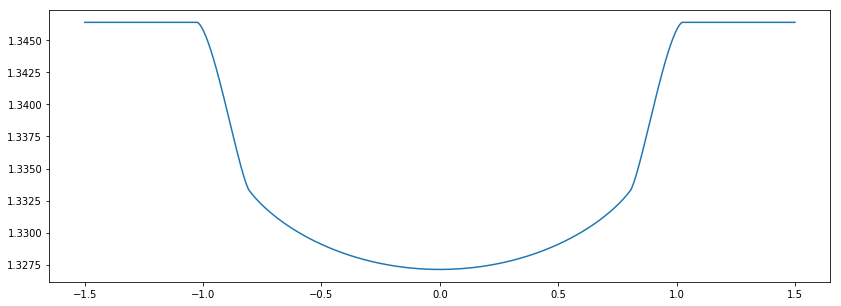

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(xo, flux);

And here are the first few gradients, normalized so we can plot them all on the same graph:

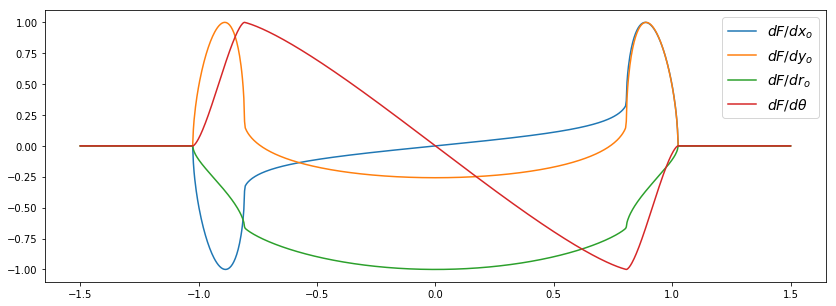

In [7]:
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(xo, gradient['xo'] / np.nanmax(np.abs(gradient['xo'])), label=r'$dF/dx_o$')
ax.plot(xo, gradient['yo'] / np.nanmax(np.abs(gradient['yo'])), label=r'$dF/dy_o$')
ax.plot(xo, gradient['ro'] / np.nanmax(np.abs(gradient['ro'])), label=r'$dF/dr_o$')
ax.plot(xo, gradient['theta'] / np.nanmax(np.abs(gradient['theta'])), label=r'$dF/d\theta$')
ax.legend(fontsize=14);

## Gradients of `System` instances

We can take gradients of `System` instances as well. Let's create a very simple star-planet system.

In [8]:
from starry.kepler import Primary, Secondary, System

# Body A
star = Primary()
star[1] = 0.4
star[2] = 0.26

# Body b
planet = Secondary()
planet.L = 1e-3
planet.r = 0.1
planet.prot = 1
planet.porb = 1
planet.ecc = 0.2
planet.w = 35
planet[1, 0] = 0.3
planet[2, -1] = 0.3
planet[2, 2] = -0.1

# System
system = System(star, planet)

As before, we request the gradient via the `gradient=True` keyword of the `compute()` method. Let's compute a super high resolution light curve with 100,000 points so we can zoom in on interesting features.

In [9]:
time = np.linspace(-1.75, 1.75, 100000)
%time system.compute(time, gradient=True)

CPU times: user 727 ms, sys: 21.1 ms, total: 748 ms
Wall time: 749 ms


We can plot the resulting light curve:

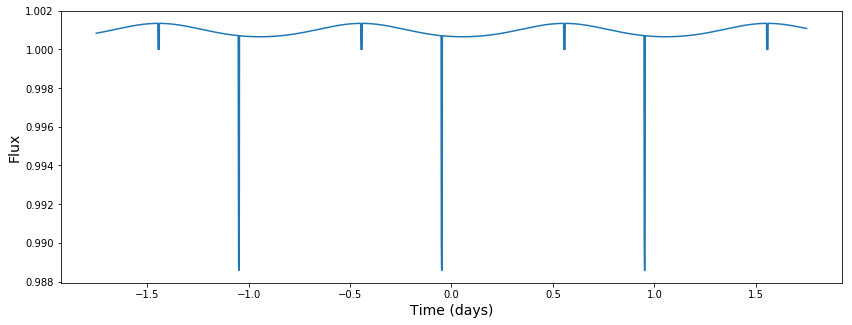

In [10]:
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(time, system.lightcurve)
ax.set_xlabel('Time (days)', fontsize=14)
ax.set_ylabel('Flux', fontsize=14);

As for the gradients, these are stored in the `gradient` attribute of the `System` instance:

In [11]:
system.gradient

{'A.prot': array([0., 0., 0., ..., 0., 0., 0.]),
 'A.tref': array([0., 0., 0., ..., 0., 0., 0.]),
 'A.u': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'b.L': array([0.8365729 , 0.83663733, 0.83670177, ..., 1.07855564, 1.07847729,
        1.07839894]),
 'b.Omega': array([nan, nan, nan, ..., nan, nan, nan]),
 'b.a': array([0., 0., 0., ..., 0., 0., 0.]),
 'b.ecc': array([-0.0005656 , -0.00056568, -0.00056576, ...,  0.00068785,
         0.00068787,  0.00068789]),
 'b.inc': array([nan, nan, nan, ..., nan, nan, nan]),
 'b.lambda0': array([ 5.11298215e-06,  5.11372724e-06,  5.11447215e-06, ...,
        -6.21812874e-06, -6.21831232e-06, -6.21849552e-06]),
 'b.porb': array([ 0.00081588,  0.000816  ,  0.00081612, ..., -0.00099223,
        -0.00099226, -0.00099229]),
 'b.prot': array([0.00240529, 0.00240558, 0.00240587, ..., 0.0049095 , 0.00490972,
        0.00490994]),
 'b.r': array([0., 0., 0., ..., 0., 0., 0.]),
 'b.tref': array([-0.00184067, -0.00184094, -0.

Note that since there are multiple bodies, the dictionary keys are prepended with the body identifier. The primary body (the star, in this case) is always given the identifier `A`. The secondary bodies are given lower case letters, starting with `b` and increasing in the order the bodies were specified when the system was instantiated.

There are a *ton* of interesting derivatives to show. But as a brief example, here's the derivative of the light curve with respect to the coefficient of the $Y_{1,1}$ spherical harmonic of the planet's map (that's the element of index $n=3$ in the vector `planet.y`):

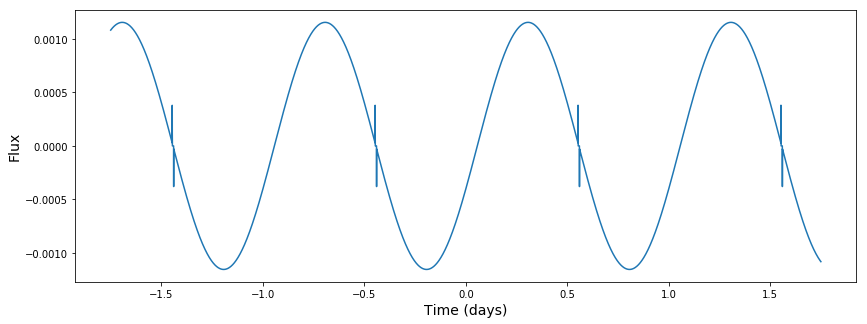

In [14]:
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(time, system.gradient['b.y'][2])
ax.set_xlabel('Time (days)', fontsize=14)
ax.set_ylabel('Flux', fontsize=14);

Cool! Let's zoom in on those spikes, which happen at secondary eclipse ingress and egress:

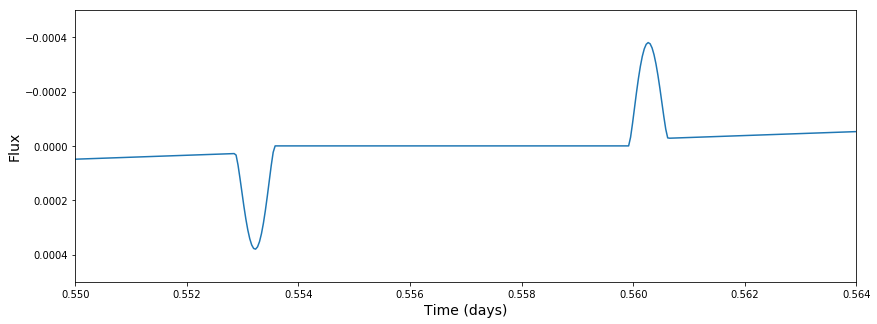

In [15]:
fig, ax = pl.subplots(1, figsize=(14, 5))
ax.plot(time, system.gradient['b.y'][2])
ax.set_xlabel('Time (days)', fontsize=14)
ax.set_ylabel('Flux', fontsize=14);
ax.set_xlim(0.55, 0.564)
ax.set_ylim(0.0005, -0.0005);

**Note:** The `Secondary` and `Primary` instances also have their own `gradient` attributes, which store the gradient of *that body's flux* with respect to each of the parameters. Check those out as well!

## All the gradients

Finally, just for fun, we can plot **all** of the gradients `starry` is able to compute for a two-planet system. Below are three snippets of the light curve: a **transit** of the inner planet (left), a **secondary eclipse** of the inner planet by the star (center), and a **planet-planet occultation** of the inner planet by the outer planet (right). The top panels show the light curve and the sub panels show the derivatives of the light curve with respect to all 28 system parameters. Blue lines are the analytic versions computed by starry, while the orange dots are computed numerically. The numerical flux is computed using an adaptive mesh and the numerical derivatives are computed using finite differences. Note that several of the numerical derivatives show significant numerical instabilities, while the analytic derivatives do not!

![](gradients.png)